Henri Drake's proof of concept applying regionate to SoHi MITgcm-style grid 

Two key changes relative to Zack's original notebook:
1) Needed to assign coordinates ["geolon", "geolat"] for the lon and lat at the center
of each cell and ["geolon_c", "geolat_c"] for the corners of each cell.
2) Since the original dataset has a "left" grid convention (with Nx_center = Nx_left),
I had to extend the dataset by clipping off the northernmost row of cell centers and
by extending the X velocities to the right by 1 column, using the left-most velocities to
effectively enforce mass conservative across the periodic boundary.

Note: Zach's original notebook said the grid was using the "right" convention, but the
actual grid coordinates suggested the velocities were actually on the "left".

In [3]:
import h5py
import xarray as xr
import os

In [11]:
os.chdir('/data/globus/zkaufman')
ds = xr.open_dataset("UVEL_snapshot.nc")
bathym_on_uv = xr.open_dataset("bathym_on_uv.nc").bathymetry
ds["deptho_on_uv"] = xr.DataArray(bathym_on_uv.values, dims=("YG", "XG")).ffill("XG").bfill("XG").ffill("YG").bfill("YG")

In [12]:
os.chdir('/data/SO2/SO24/ANDY/SOHI/Data/Models/SOHI/meta/')
og = 'GRID_v8.mat'
og = h5py.File(og, 'r')

XC = og['XC'][0,:]  # center 
DXC = og['DXC'][0,:] 

XG = og['XG'][0,:] # edge 
DXG = og['DXG'][0,:]

YC = og['YC'][:2541,0]
DYC = og['DYC'][:2541,0]

YG = og['YG'][:2541,0]
DYG = og['DYG'][:2541,0]

ds = ds.assign_coords(
    XC=("XC", XC),
    DXC=("XC", DXC),
    XG=("XG", XG),
    DXG=("XG", DXG),
    YC=("YC", YC),
    DYC=("YC", DYC),
    YG=("YG", YG),
    DYG=("YG", DYG)
)

# Create synthetic V velocity
ds["VVEL"] = xr.zeros_like(xr.broadcast(ds.YG, ds.XC)[0])

In [13]:
# Define regionate shelf polygon for evaluating heat flux convergence 
from xgcm import Grid

coords={'X': {'center': 'XC', 'left': 'XG'},
                        'Y': {'center': 'YC', 'left': 'YG'}}
boundary = {'X':'periodic', 'Y':'extend', 'Z':'extend'}
grid = Grid(ds,coords=coords,boundary=boundary,autoparse_metadata=False)

In [14]:
ds_xouter = xr.concat([
    ds, ds.isel(XG=[0]).assign_coords({"XG":xr.DataArray(ds.XG.isel(XG=[0]).values + 360., dims=("XG",))})
], dim="XG", data_vars="minimal").rename({"XG":"XO"})
ds_xyouter = ds_xouter.isel(YC=slice(None, -1)).rename({"YG":"YO"})

geolon, geolat = xr.broadcast(ds_xyouter.XC, ds_xyouter.YC)
geolon_c, geolat_c = xr.broadcast(ds_xyouter.XO, ds_xyouter.YO)
ds_xyouter = ds_xyouter.assign_coords({"geolon":geolon, "geolat":geolat, "geolon_c":geolon_c, "geolat_c":geolat_c})


In [15]:
# Define regionate shelf polygon for evaluating heat flux convergence 
from xgcm import Grid

coords={'X': {'center': 'XC', 'outer': 'XO'},
                        'Y': {'center': 'YC', 'outer': 'YO'}}
boundary = {'X':'periodic', 'Y':'extend', 'Z':'extend'}
grid = Grid(ds_xyouter,coords=coords,boundary=boundary,autoparse_metadata=False)

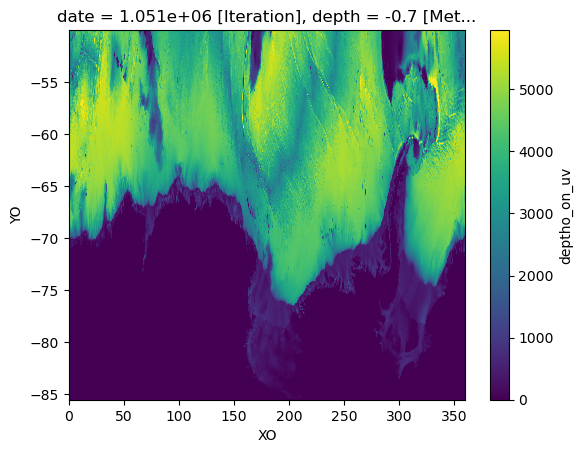

In [16]:
ds_xyouter.deptho_on_uv.plot()

In [17]:
ds_xyouter["deptho"] = grid.interp(grid.interp(ds_xyouter.deptho_on_uv, "X"), "Y")

In [18]:
import regionate as reg
name = "Southern Shallows"
mask = (ds_xyouter.deptho <= 1000.) & (ds_xyouter.YC <= -60)
region_dict = reg.MaskRegions(mask, grid).region_dict
region = region_dict[0] # pick out the first region, corresponding to the longest contour

# Make a region object to keep track of useful properties of the mask
region = reg.GriddedRegion(
    "AIS",
    region.lons_c[::-1], # reverse direction so that the boundary has a west-to-east orientation
    region.lats_c[::-1],
    grid,
    ij=(region.i_c[::-1], region.j_c[::-1])
)

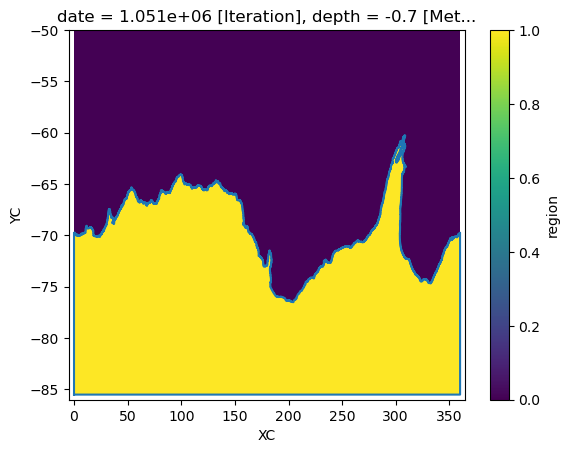

In [20]:
import matplotlib.pyplot as plt 
region.mask.plot(x="XC")
plt.plot(region.lons_c, region.lats_c)
plt.ylim(-86, -50)
plt.xlim(-5, 365);

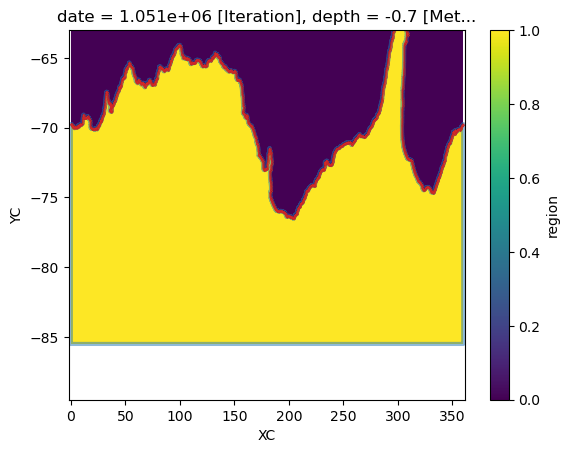

In [21]:
import numpy as np
idx_without_border = (
    (region.lons_c != ds_xyouter.XO.min().values) &
    (region.lons_c != ds_xyouter.XO.max().values) &
    (region.lats_c != np.min(region.lats_c))
)

region.mask.plot(x="XC")
plt.plot(region.lons_c, region.lats_c, "C0-", alpha=0.5, markersize=1, lw=3, label="full region boundary")
plt.plot(region.lons_c[idx_without_border], region.lats_c[idx_without_border], "C3.-", lw=0.5, markersize=0.1, label="isobath only (ignoring grid boundaries)")
plt.ylim(-89.5, -63)
plt.xlim(-2, 362);

In [22]:
import sectionate as sec
flux = sec.convergent_transport(
    grid,
    region.i_c[:-1][idx_without_border],
    region.j_c[:-1][idx_without_border],
    utr="UVEL",
    vtr="VVEL",
    layer=None,
    interface=None
)

/home/zkaufman/miniconda3/envs/base_env/lib/python3.12/site-packages/sectionate/transports.py:393: UserWarning: The orientation of open sections is ambiguous–verify that it matches expectations!
  warnings.warn("The orientation of open sections is ambiguous–verify that it matches expectations!")


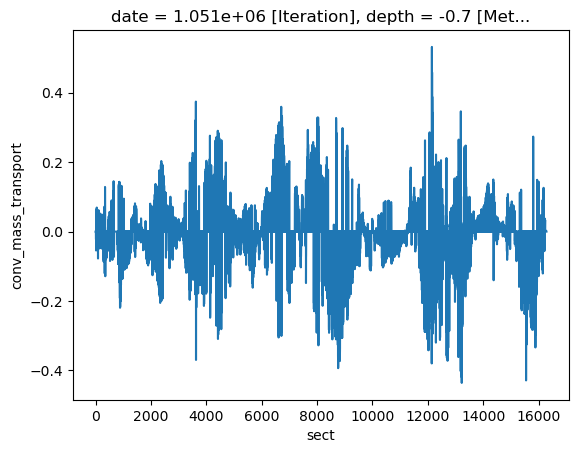

In [23]:
flux.conv_mass_transport.plot()